In [232]:
%matplotlib inline

In [233]:
import time
import numpy as np
import pandas as pd
import os

from datetime import datetime
from matplotlib import pyplot as plt

from scipy import optimize

import seaborn as sbn
from seaborn import 

# The Student Performance Data

In [234]:
def get_dataset(url):
    filename = url.rsplit("/")[-1]
    urlretrieve(url, filename)

    compressed = zipfile.ZipFile(filename)
    compressed.extractall('.', members=[i.filename for i in compressed.infolist() if not i.filename.startswith('__')])
    compressed.close()

    folder = filename.rstrip('.zip')
    os.renames(folder + '/data', 'data')

    os.remove(filename)
    shutil.rmtree(folder)

In [235]:
df_mat = pd.read_csv('data/student-mat.csv', sep=';')
df_por = pd.read_csv('data/student-por.csv', sep=';')

# Seperate Training and Testing Set

In [236]:
def assign_to_set(df):

    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False,
    )
    df.ix[sampled_ids, 'for_testing'] = True
    return df

# Save You Files

In [237]:
df_mat['for_testing'] = False

grouped = df_mat.groupby('school', group_keys=False).apply(assign_to_set)

df_mat_train = df_mat[grouped.for_testing == False]
df_mat_test  = df_mat[grouped.for_testing == True]

df_mat_train.to_csv('data/student_math_training.csv')
df_mat_test.to_csv('data/student_math_test.csv')

# Artificial Neural Network Implementation

<h3 align = 'center'> Variables </h3>

|Code Symbol | Math Symbol | Definition | Dimensions
| :-: | :-: | :-: | :-: |
|X|$$X$$|Input Data, each row in an example| (numExamples, inputLayerSize)|
|y |$$y$$|target data|(numExamples, outputLayerSize)|
|W1 | $$W^{(1)}$$ | Layer 1 weights | (inputLayerSize, hiddenLayerSize) |
|W2 | $$W^{(2)}$$ | Layer 2 weights | (hiddenLayerSize, outputLayerSize) |
|z2 | $$z^{(2)}$$ | Layer 2 activation | (numExamples, hiddenLayerSize) |
|a2 | $$a^{(2)}$$ | Layer 2 activity | (numExamples, hiddenLayerSize) |
|z3 | $$z^{(3)}$$ | Layer 3 activation | (numExamples, outputLayerSize) |
|J | $$J$$ | Cost | (1, outputLayerSize) |

In [238]:
class NeuralNet:

    def __init__(self):        
        # Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        # Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

# Double Check Gradient

In [239]:
def computeNumericalGradient(N, X, y):
    paramsInitial = N.getParams()
    numgrad = np.zeros(paramsInitial.shape)
    perturb = np.zeros(paramsInitial.shape)
    e = 1e-4

    for p in range(len(paramsInitial)):
        #Set perturbation vector
        perturb[p] = e
        N.setParams(paramsInitial + perturb)
        loss2 = N.costFunction(X, y)

        N.setParams(paramsInitial - perturb)
        loss1 = N.costFunction(X, y)

        #Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)

        #Return the value we changed to zero:
        perturb[p] = 0

        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 

# Instantiate and Set Data

In [240]:
class Trainer:
    
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res
    

#Plot projections of our new data:

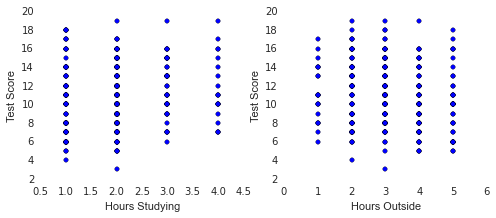

In [241]:
fig = plt.figure(0,(8,3))

plt.subplot(1,2,1)
plt.scatter(trainX[:,0], trainY)
plt.grid(1)
plt.xlabel('Hours Studying')
plt.ylabel('Test Score')

plt.subplot(1,2,2)
plt.scatter(trainX[:,1], trainY)
plt.grid(1)
plt.xlabel('Hours Outside')
plt.ylabel('Test Score')

#Normalize

In [242]:
NN = NeuralNet()

trainX = np.array(df_mat_train[['studytime', 'goout']])
trainY = np.array(df_mat_train[['G1']])



# Train network with new data:

In [243]:
T = Trainer(NN)

In [244]:
T.train(trainX, trainY)

         Current function value: 19013.784191
         Iterations: 0
         Function evaluations: 46
         Gradient evaluations: 34


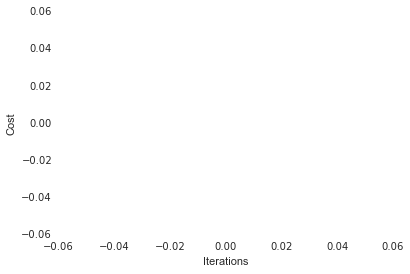

In [245]:
#Plot cost during training:
plt.plot(T.J)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [246]:
#Test network for various combinations of sleep/study:
hoursSleep = np.linspace(0, 10, 100)
hoursStudy = np.linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [247]:
allOutputs = NN.forward(allInputs)

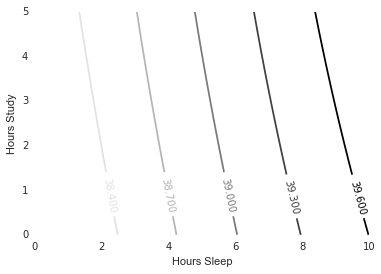

In [248]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = plt.contour(xx,yy,100*allOutputs.reshape(100, 100))
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')

In [249]:
from mpl_toolkits.mplot3d import Axes3D

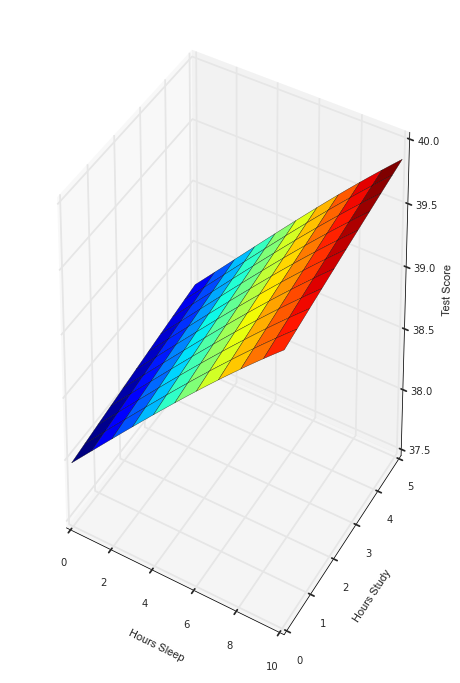

In [250]:
fig = plt.figure(figsize=(8,12))

ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), cmap=plt.cm.jet)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')